# Segmentación RFM
## Conexión con la Base Datos

In [1]:
# Importar las bibliotecas necesarias
# Librerías para interactuar con el entorno
import os
import sys

sys.path.append("..\\procesamiento")  # Buscar las funciones en la carpeta procesamiento

# Manipulación de dataframes
import pandas as pd

# Herramientas para la visualización
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()  # Estableciendo el tema estándar

# Importando módulos propios del proyecto
from df_rfm import create_datafile

In [30]:
# Nombre del archivo
filename = "rfm.pkl"

# Ejecutando la consulta para crear un archivo pickle
create_datafile(filename)                           # Nombre predeterminado para el archivo rfm.pkl - ubicado en la carpeta de datos

# Guardando la ruta del archivo de datos
path_parent = os.path.dirname(os.getcwd())          # Obteniendo la ruta del directorio padre
path_archivo = path_parent + "\\data\\" + filename  # Construyendo la ruta completa del archivo

df = pd.read_pickle(path_archivo)                   # Leyendo el archivo pickle y almacenándolo en un DataFrame
df.head()                                           # Mostrando la cabecera del dataframe

,customer_id,purchase_date,amount
0,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,24.39
1,7a5d8efaaa1081f800628c30d2b0728f,2017-12-06 12:04:06,107.78
2,15fd6fb8f8312dbb4674e4518d6fa3b3,2018-05-21 13:59:17,128.45
3,a24e6f72471e9dbafcb292bc318f4859,2018-05-07 13:20:41,96.12
4,68c9dafdf193586c290b19c71541357a,2018-07-22 14:07:35,341.09


In [24]:
# Mostrando información del dataframe
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   customer_id    103886 non-null  object        
 1   purchase_date  103886 non-null  datetime64[ns]
 2   amount         103886 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.4+ MB


## Análisis RFM

Para hacer el análisis **R**ecency **F**requency **M**onetary-Value **(RFM)**. Necesitamos información de las fechas de compra, los ids de los clientes y cuánto han gastado. Para ello necesitamos información de las tablas **orders** y **order_payments**. El análisis se hará en un principio para toda la base de datos. Estos análisis se pueden hacer de manera trimestral por ejemplo o en otras escalas de tiempo dependiendo de cuál sea el objetivo del análisis.

### Data Wrangling

In [31]:
# Sort dataset by purchase datetime
df.sort_values(by="purchase_date", inplace=True)

# Reset index
df.reset_index(inplace=True)

# Drop index column
df.drop("index", axis=1, inplace=True)

In [33]:
# Mapping ids to numbers
dict_id = {}

for key, id in enumerate(df["customer_id"].unique()):
    dict_id[id] = key

In [34]:
# Asignando números como ids (simplemente para que se vea mejor visualmente)
df["customer_id"] = df["customer_id"].map(dict_id)

In [35]:
# Mostrando el dataframe
df

,customer_id,purchase_date,amount
0,0,2016-09-04 21:15:19,136.23
1,1,2016-09-05 00:15:34,75.06
2,2,2016-09-13 15:24:19,40.95
3,3,2016-10-02 22:07:52,109.34
4,4,2016-10-03 09:44:50,45.46
...,...,...,...
103881,99435,2018-09-29 09:13:03,137.03
103882,99436,2018-10-01 15:30:09,80.38
103883,99437,2018-10-03 18:55:29,197.55
103884,99438,2018-10-16 20:16:02,222.03


In [ ]:
# Información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   customer_id    103886 non-null  int64         
 1   purchase_date  103886 non-null  datetime64[ns]
 2   amount         103886 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.4 MB


### Cálculo del Recency

Tomemos como la última fecha para establecer la comparación. La fecha de la última compra. De esa manera para algún usuario cualquiera el recency se calcularía acá como:

$$\text{Recency} = \text{Fecha actual} - \text{Fecha de la última compra del usuario}$$

El Recency que aparecerá en la tabla como $R$ está en la escala de días.

In [ ]:
# Cálculo de la última fecha
time_max = df["purchase_date"].max()

In [ ]:
# Cálculo de días desde la última compra (anexado al dataframe como R)
Recency = (time_max - df.groupby("customer_id")["purchase_date"].max()).dt.days

# Mapeando la columna de Recency
# df["Recency"] = df["customer_id"].map(Recency)

In [ ]:
Recency

customer_id
0        113
1        315
2        149
3        163
4         87
        ... 
99435    342
99436    328
99437    223
99438    425
99439     70
Name: purchase_date, Length: 99440, dtype: int64

In [ ]:
# Creación del dataframe
df_rfm = pd.DataFrame()

# Asignación del Recency
df_rfm.index = Recency.index
df_rfm["Recency"] = Recency.values

### Frequency

In [ ]:
# Cálculo del Frequency
Frequency = df.groupby("customer_id")["customer_id"].count()

# Asignación del Frequency
df_rfm["Frequency"] = Frequency

### Monetary Value

In [ ]:
# Cálculo del Monetary Value
Monetary_Value = df.groupby("customer_id")["amount"].sum()

# Asignación del Monetary Value
df_rfm["Monetary_Value"] = Monetary_Value

## Variables RFM

Para la creación de las variables $RFM$ vamos a dividir cada una de las columnas (Recency, Frequency y Monetary_Value) en 5 partes.

In [ ]:
# Muestra del dataframe RFM
df_rfm

,Recency,Frequency,Monetary_Value
customer_id,,,
0,113,1,24.39
1,315,1,107.78
2,149,1,128.45
3,163,1,96.12
4,87,1,341.09
...,...,...,...
99435,342,1,90.28
99436,328,1,47.62
99437,223,1,363.31


In [ ]:
list_rfm = ["R", "F", "M"]

# Mapping the categories
dict_cat = {}

for key, id in enumerate(pd.cut(df_rfm["Recency"], 5).unique().sort_values(ascending=False)):
    dict_cat[id] = key+1

# Calculando R
df_rfm["R"] = pd.cut(df_rfm["Recency"], 5).map(dict_cat)



# Mapping the categories
dict_cat = {}

for key, id in enumerate(pd.cut(df_rfm["Frequency"], 5).unique().sort_values()):
    dict_cat[id] = key+1

# Calculando F
df_rfm["F"] = pd.cut(df_rfm["Frequency"], 5).map(dict_cat)



# Mapping the categories
dict_cat = {}

for key, id in enumerate(pd.cut(df_rfm["Monetary_Value"], 5).unique().sort_values()):
    dict_cat[id] = key+1

# Calculando M
df_rfm["M"] = pd.cut(df_rfm["Monetary_Value"], 5).map(dict_cat)

# Transformar Monetary Value a entero
df_rfm["M"] = df_rfm["M"].astype(int)

In [ ]:
df_rfm

,Recency,Frequency,Monetary_Value,R,F,M
customer_id,,,,,,
0,113,1,24.39,5,1,1
1,315,1,107.78,3,1,1
2,149,1,128.45,5,1,1
3,163,1,96.12,4,1,1
4,87,1,341.09,5,1,1
...,...,...,...,...,...,...
99435,342,1,90.28,3,1,1
99436,328,1,47.62,3,1,1
99437,223,1,363.31,4,1,1


### Creation of the RFM column

In [ ]:
df_rfm["RFM"] = df_rfm["R"].astype(str) + df_rfm["F"].astype(str) + df_rfm["M"].astype(str)
df_rfm["RFM"] = df_rfm["RFM"].astype(int)

In [ ]:
df_rfm

,Recency,Frequency,Monetary_Value,R,F,M,RFM
customer_id,,,,,,,
0,113,1,24.39,5,1,1,511
1,315,1,107.78,3,1,1,311
2,149,1,128.45,5,1,1,511
3,163,1,96.12,4,1,1,411
4,87,1,341.09,5,1,1,511
...,...,...,...,...,...,...,...
99435,342,1,90.28,3,1,1,311
99436,328,1,47.62,3,1,1,311
99437,223,1,363.31,4,1,1,411


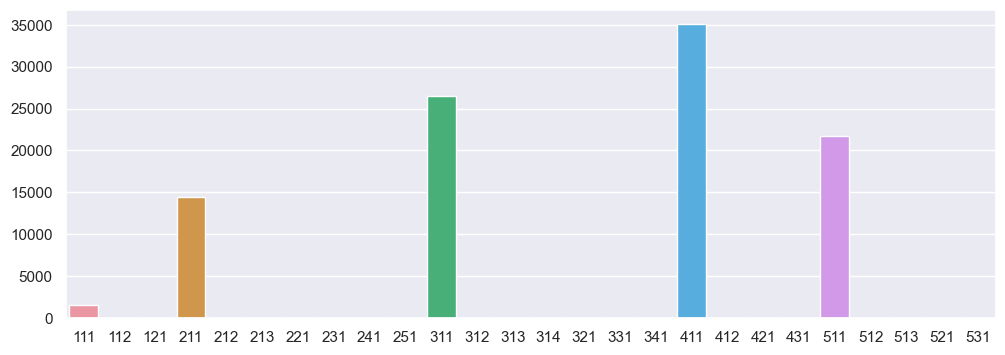

In [ ]:
_, ax = plt.subplots(figsize=(12,4))

rfm_values = df_rfm["RFM"].value_counts().sort_index()

sns.barplot(x=rfm_values.index, y=rfm_values.values);

## RFM visualizations

In [ ]:
def hist_plot(data: pd.DataFrame, column: str, bins=20, kde=False) -> None:

    _, ax = plt.subplots(figsize=(12,4))

    sns.histplot(data=data, x=column, bins=bins, kde=kde, ax=ax);
    return None



def count_plot(data: pd.DataFrame, column: str) -> None:

    _, ax = plt.subplots(figsize=(12,4))

    values = data[column].value_counts().sort_index()

    sns.barplot(data=data, x=values.index, y=values.values , ax=ax)
    ax.set_xlabel(column);
    return None

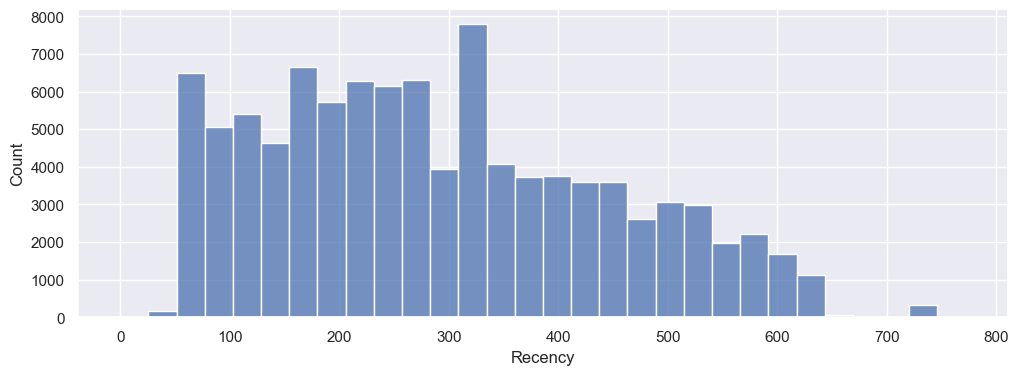

In [ ]:
hist_plot(data=df_rfm, column="Recency", bins=30)

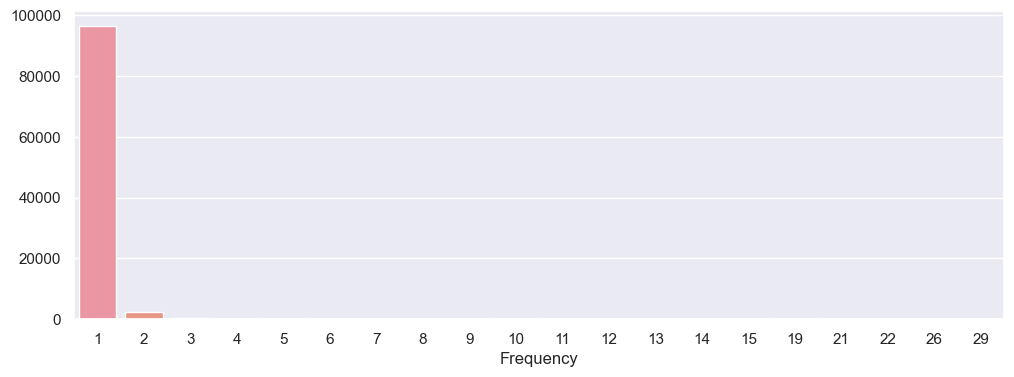

In [ ]:
count_plot(data=df_rfm, column="Frequency") 

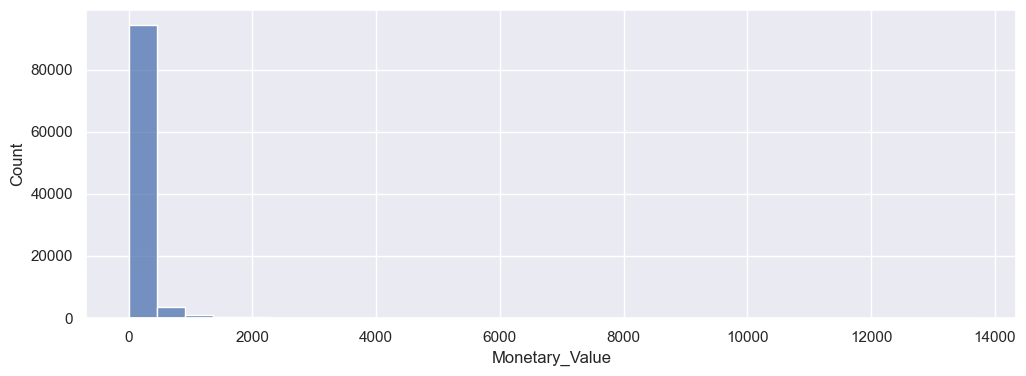

In [ ]:
hist_plot(data=df_rfm, column="Monetary_Value", bins=30)

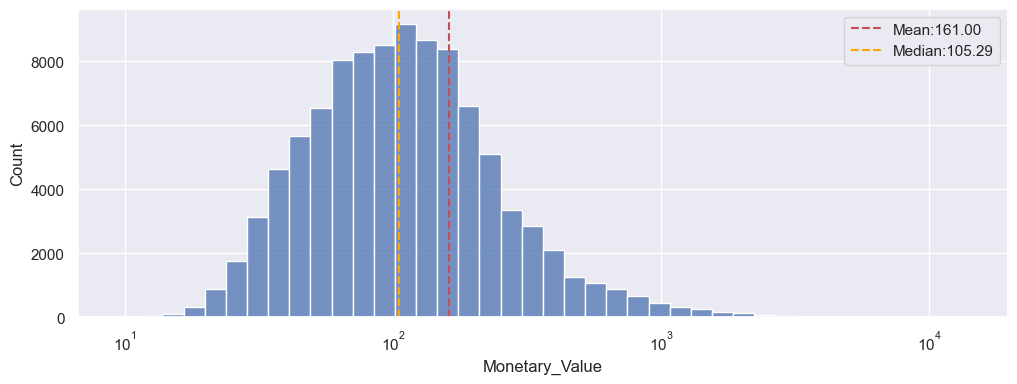

In [ ]:
_, ax = plt.subplots(figsize=(12,4))

data_mv = df_rfm[df_rfm["Monetary_Value"] > 0]

sns.histplot(data=data_mv, x="Monetary_Value", log_scale=True, bins=40, ax=ax)

ax.axvline(data_mv["Monetary_Value"].mean(), c="r", ls="--", label=f"Mean:{data_mv['Monetary_Value'].mean():.2f}")
ax.axvline(data_mv["Monetary_Value"].median(), c="orange", ls="--", label=f"Median:{data_mv['Monetary_Value'].median():.2f}")
plt.legend();

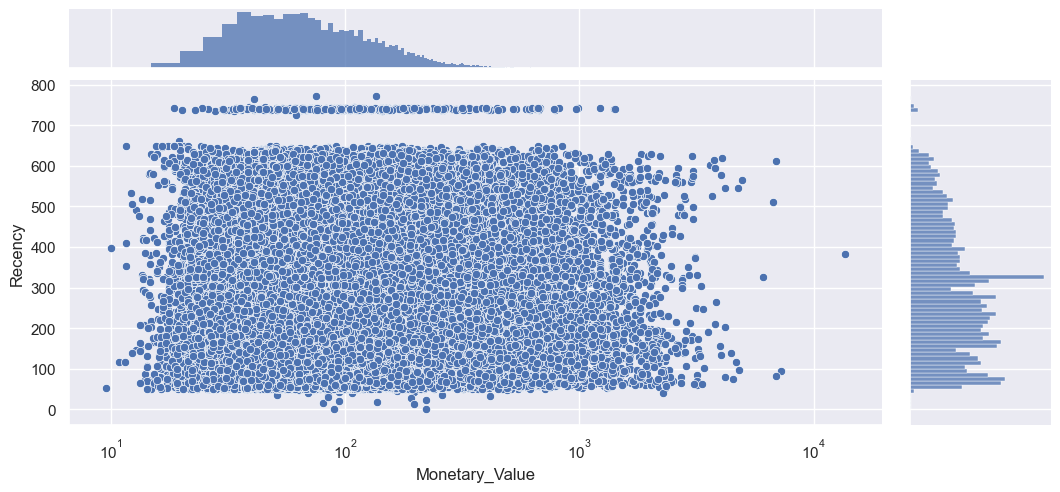

In [ ]:
g = sns.jointplot(data=df_rfm, x="Monetary_Value", y="Recency", height=5)
g.ax_joint.set_xscale('log')
g.fig.set_size_inches((12, 5))